<a href="https://colab.research.google.com/github/jbeans0312/484homework/blob/master/Bean_MNIST_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment and Data Configuration**

### Import libraries and configure device

In [96]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import confusion_matrix

# if we can run the code on the gpu, do it! otherwise, we run on the cpu (booo)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Set our hyper-params


In [75]:
input_size = 784 # number of input nodes (each image is 28x28 px)
hidden_size = 500 # size of the hidden layer (between i/o)
hidden_num = 2 # number of hidden layers (between i/o)
num_classes = 10 # number of output labels (we will be taking max prob)
num_epochs = 2  # number of epochs, during each epoch we train on all images
batch_size = 100 # number of images we train on at a given time
learning_rate = 0.001 # used in gradient descent 

### Import the MNIST data

In [76]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

### Load the MNIST data

In [77]:
# we utilize the batch size we defined and we opt to shuffle the data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

### Visualizing Dataset


The data is a series of 60,000 28x28 px images, these are some examples
- label (top)
- image (bottom)

5


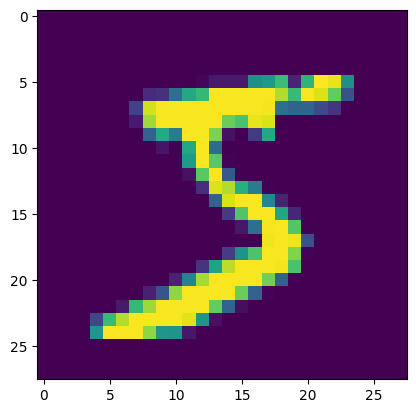

0


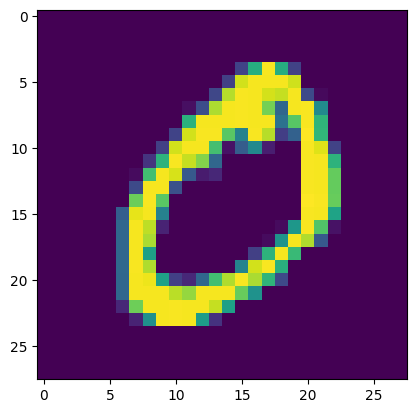

4


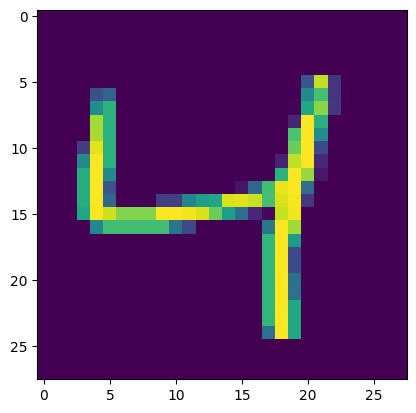

1


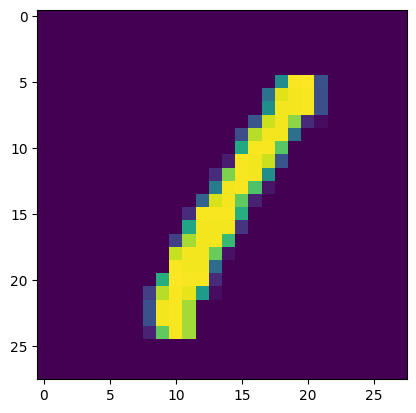

9


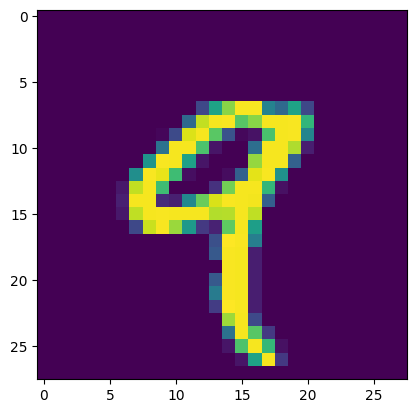

In [78]:
for i in range(5):
  example_i = train_loader.dataset[i][0].reshape(28,28)
  plt.imshow(example_i)
  print(train_loader.dataset[i][1])
  plt.show()

# **Metrics**




### Accuracy Evaluation

In [93]:
def acc_eval(preds, labels):
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Finding True/False Positive

In [97]:
# True positive: Predicted to be a number n, is actually that number n
# False positive: Predicted to be a number n, is actually another number m
# True negative: Predicted to NOT be a number n, is actually not that number n
def tp_fp(preds, labels):
  plt.figure(figsize=(10,6))
  fx = sns.heatmap(confusion_matrix(labels, preds), annot=True,
                   fmt=".2f", cmap="GnBu")
  fx.set_title('Confusion Matrix\n')
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n')
  l = ['0','1','2','3','4','5','6','7','8','9']
  fx.xaxis.set_ticklabels(l)
  fx.yaxis.set_ticklabels(l)
  plt.show()


# **Feed Forward NN**

### Create NeuralNet class utilizing Torch NN module

In [65]:
# fully connected neural network with one hidden layer

# implement functionality for finetuning hidden_size and hidden_layer_num
# hidden_size = number of nodes per layer
# hidden_num = number of layers in the ****hidden zone*****

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, hidden_num):
        """Python note: we use super().__init__() to inherit all 
        values initialized in the parent (super) class. In this case
        there are probably a bunch of variables predefined in the Torch
        NN class that we need to access, but don't want to mess with."""
        super(NeuralNet, self).__init__() 
        """We set the rest of the attributes to OUR hyper-params that we 
        defined in [3]"""
        # here we init ReLU
        self.relu = nn.ReLU() # ReLU acivation function from torch
        self.accuracy_function = accuracy_function
        self.input_size = input_size # here we specify the input size
        self.hidden_num = hidden_num # here we specify the num of hidden layers
       
        # Create our layers
        
        self.input_layer = nn.Linear(input_size, hidden_size) # first layer
        
        self.hidden_layers = nn.ModuleList() # list for remaining hidden layers
        
        for i in range(0, hidden_num): # create remaining layers
          self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.output_layer = nn.Linear(hidden_size, num_classes) # output layer
    
    """Here we define our feed forward method, we won't be using softmax at
    the moment, but we will be utilizing it later. 
    
    Torch note: Every nn.Module subclass implements the operations in the 
    forward method on the data."""
    def forward(self, x):
        # Utilize hidden layers and apply activation (ReLU)
        out = self.relu(self.input_layer(x)) # input layer

        for i in range(self.hidden_num): # hidden layers
          out = self.relu(self.hidden_layers[i](out))

        out = self.output_layer(out) # output layer
        return out

model = NeuralNet(input_size, hidden_size, num_classes, hidden_num).to(device)

### Function to calculate total parameters

In [66]:
def count_parameters(model):
  # p.numel() sums all the combinations of parameters
  # p.numel([500,500]) yields 500^2 params 
    return sum(p.numel() for p in model.parameters())

### Initialize loss function (criterion) and optimizer

In [67]:
"""
Here we select Cross Entropy Loss (CEL) as our loss function. We choose CEl as 
it is well suited for multi-class classification problems, and produces models
that make predictions with high confidence. 

Note: we could also try implementing Negative Log Likelihood Loss (NLL), as it 
is also well suited for mcc problems.
"""
criterion = nn.CrossEntropyLoss() # softmax is built in
"""
Adam is a pytorch method for implementing a stochastic optimization algorithm.
Adam falls under the umbrella of gradient descent algorithms, and is effecient
for working with large batches of data (like MNIST)--or I guess MNIST isn't that
large in the scheme of large things :o
"""
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Create training loop


In [ ]:
n_total_steps = len(train_loader) # get the total number of training instances

"""
Here we utilize a nested for loop since we need to iterate over epochs, and 
train in batches inside of those epochs.
"""
for epoch in range(num_epochs): 
  for i, (images, labels) in enumerate(train_loader):
    """
    We need to reshape the training data since it comes packed in a tuple 
    containing a matrix of pixel values and a target value, we want it to be a 
    1D so we can feed the data into our net
    """
    images = images.reshape(-1, 28*28).to(device) # reshape the data
    labels = labels.to(device) # upload the labels to the device 
    """
    Here we pass our image data arr[input_size] through the model and calculate
    the loss function.
    """
    outputs = model(images) # run the input data through our model
    loss = criterion(outputs, labels) # run the loss function (CLE)
    """
    Now that we have the output from our loss function, we preform stochastic
    (one at a time) gradient descent optimization using Adam. This updates our
    weights after every training instance.
    """
    optimizer.zero_grad() # initializes the gradient tensor to zero 
    loss.backward() # back-prop and compute the gradient
    optimizer.step() # preform a single optimization step 
    """
    To track our runtime progress we will print the loss function after every 
    100th step and show our total steps.
    """
    if (i+1) % 100 == 0:
      print(f'Epoch[{epoch+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

### Evaluate metrics

Accuracy: 98.0000%


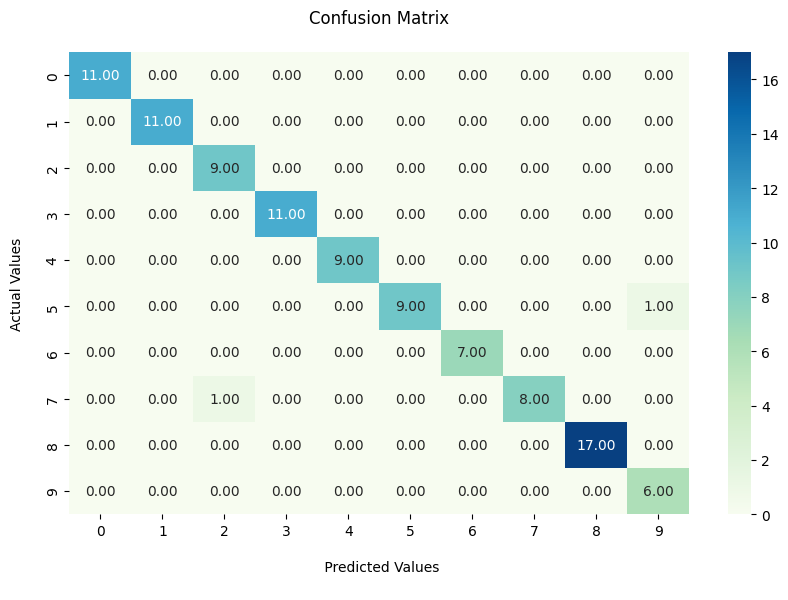

In [98]:
# Evaluate accuracy for
with torch.no_grad(): # ensure that we do not update the weights on accident
  preds = torch.max(outputs, dim=1)[1]
  acc = acc_eval(preds, labels)
  print(f'Accuracy: {acc.item()*100:.4f}%') 

  tp_fp(preds, labels)